<a href="https://colab.research.google.com/github/Lizette95/Team_RM5_ClassificationPredict_Notebook/blob/master/Team_RM5_LogReg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Ignore warnings
import warnings
warnings.simplefilter(action='ignore')

# Prerequisites
#import sys
#!{sys.executable} -m pip install wordcloud comet_ml scikit-learn

# Load Dependencies
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from wordcloud import WordCloud
from gensim.models import Phrases
from nltk.corpus import stopwords
from sklearn.utils import resample
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# Display
%matplotlib inline
sns.set(font_scale=1)
sns.set_style("white")

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
train1 = train.copy()
test1 = test.copy()

In [ ]:
# view the data
train.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [ ]:
test.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


In [ ]:
print(train.shape)
print(test.shape)

(15819, 3)
(10546, 2)


In [ ]:
#null values
train.isnull().sum()

sentiment    0
message      0
tweetid      0
dtype: int64

In [ ]:
test.isnull().sum()

message    0
tweetid    0
dtype: int64

In [ ]:
#check for empty strings
blanks = []
for i,s,m,ti in train.itertuples():
    if m.isspace():
        blanks.append(i)
len(blanks)

0

In [ ]:
blanks = []
for i,m,ti in test.itertuples():
    if m.isspace():
        blanks.append(i)
len(blanks)

0

In [ ]:
#no null values or empty strings

In [ ]:
#how many tweets were for each sentiment
type_sum = train.groupby(['sentiment']).count()
type_sum.sort_values('message', ascending=False, inplace=True)
type_sum

,message,tweetid
sentiment,,
1,8530,8530
2,3640,3640
0,2353,2353
-1,1296,1296


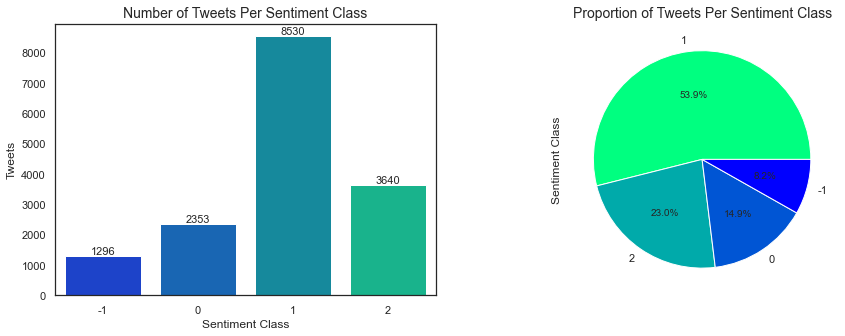

In [ ]:
# Number of Tweets Per Sentiment Class
fig, axis = plt.subplots(ncols=2, figsize=(15, 5))

ax = sns.countplot(x='sentiment',data=train,palette='winter',ax=axis[0])
axis[0].set_title('Number of Tweets Per Sentiment Class',fontsize=14)
axis[0].set_xlabel('Sentiment Class')
axis[0].set_ylabel('Tweets')
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), fontsize=11, ha='center', va='bottom')

train['sentiment'].value_counts().plot.pie(autopct='%1.1f%%',colormap='winter_r',ax=axis[1])
axis[1].set_title('Proportion of Tweets Per Sentiment Class',fontsize=14)
axis[1].set_ylabel('Sentiment Class')
    
plt.show()

In [ ]:
contractions = {"ain't": "am not", "aren't": "are not", "can't": "cannot", "can't've": "cannot have", "'cause": "because", "could've": "could have", "couldn't": "could not", "couldn't've": "could not have", "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'd've": "he would have", "he'll": "he will", "he'll've": "he will have", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "i'd": "I would", "i'd've": "I would have", "i'll": "I will", "i'll've": "I will have", "i'm": "I am", "i've": "I have", "isn't": "is not", "it'd": "it had", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have", "mightn't": "might not", "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have", "so's": "so is", "that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there had", "there'd've": "there would have", "there's": "there is", "they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we had", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'alls": "you alls", "y'all'd": "you all would", "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have", "you'd": "you had", "you'd've": "you would have", "you'll": "you you will", "you'll've": "you you will have", "you're": "you are", "you've": "you have"}
contractions_re = re.compile('(%s)' % '|'.join(contractions.keys()))
def expand_contractions(text):
    """
    Expand contractions using dictionary of contractions.
    """
    text = text.lower()
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

train['message'] = train['message'].apply(expand_contractions)
test['message'] = test['message'].apply(expand_contractions)

In [ ]:
http_regex = re.compile(r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+')
url_regex = re.compile(r'[-a-zA-Z0–9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0–9@:%_\+.~#?&//=]*)')
rt_regex = re.compile('^(RT|rt)( @\w*)?')
def remove_noise(tweet):
    """
    Remove noise from text data, such as newlines, punctuation, URLs and numbers.
    """
    new_tweet = tweet.replace('\n',' ') #Remove Newlines
    new_tweet = new_tweet.replace('"',' ') #Remove Text Delimeters
    new_tweet = new_tweet.replace('&amp',' ') #Remove Ampersands
    new_tweet = http_regex.sub('', new_tweet) #Remove http URLs
    new_tweet = url_regex.sub('', new_tweet) #Remove other URLs
    new_tweet = rt_regex.sub('', new_tweet) #Remove RTs
    new_tweet = re.sub(r'#(RT|rt)*', '', new_tweet) #Remove RTs
    new_tweet = re.sub(r'@\w*', '', new_tweet) #Remove Mentions
    new_tweet = re.sub('\w*\d\w*','', new_tweet) #Remove Numbers/Words with Numbers
    new_tweet = re.sub('[^a-zA-z\s]', '', new_tweet) #Remove Punctuation
    new_tweet = new_tweet.strip() #Remove Excess Whitespace
    return new_tweet

train['message'] = train['message'].apply(remove_noise)
test['message'] = test['message'].apply(remove_noise)

In [ ]:
train.head()

,sentiment,message,tweetid
0,1,polyscimajor epa chief does not think carbon d...,625221
1,1,it is not like we lack evidence of anthropogen...,126103
2,2,researchers say we have three years to act on ...,698562
3,1,todayinmaker wired was a pivotal year in the...,573736
4,1,it is and a racist sexist climate change deny...,466954


In [ ]:
train = train.drop('tweetid', axis=1)
train['sentiment'] = train.pop('sentiment')
train.head()

,message,sentiment
0,polyscimajor epa chief does not think carbon d...,1
1,it is not like we lack evidence of anthropogen...,1
2,researchers say we have three years to act on ...,2
3,todayinmaker wired was a pivotal year in the...,1
4,it is and a racist sexist climate change deny...,1


In [ ]:
tweetid = test['tweetid'] #Save for Output File
test = test.drop('tweetid', axis=1)
test.head()

,message
0,europe will now be looking to china to make su...
1,combine this with the polling of staffers re c...
2,the scary unimpeachable evidence that climate ...
3,putin got to you too jill trump does not bel...
4,female orgasms cause global warming sarcastic ...


In [ ]:
# Lematise posts
lemmatizer = WordNetLemmatizer()
train['lemma'] = [' '.join([lemmatizer.lemmatize(word) for word in text.split(' ')])for text in train['message']]
test['lemma'] = [' '.join([lemmatizer.lemmatize(word) for word in text.split(' ')])for text in test['message']]

In [ ]:
train.head()

,message,sentiment,lemma
0,polyscimajor epa chief does not think carbon d...,1,polyscimajor epa chief doe not think carbon di...
1,it is not like we lack evidence of anthropogen...,1,it is not like we lack evidence of anthropogen...
2,researchers say we have three years to act on ...,2,researcher say we have three year to act on cl...
3,todayinmaker wired was a pivotal year in the...,1,todayinmaker wired wa a pivotal year in the ...
4,it is and a racist sexist climate change deny...,1,it is and a racist sexist climate change deny...


In [ ]:
train['sentiment'] = train.pop('sentiment')
train.head()

,message,lemma,sentiment
0,polyscimajor epa chief does not think carbon d...,polyscimajor epa chief doe not think carbon di...,1
1,it is not like we lack evidence of anthropogen...,it is not like we lack evidence of anthropogen...,1
2,researchers say we have three years to act on ...,researcher say we have three year to act on cl...,2
3,todayinmaker wired was a pivotal year in the...,todayinmaker wired wa a pivotal year in the ...,1
4,it is and a racist sexist climate change deny...,it is and a racist sexist climate change deny...,1


In [ ]:
#Check for stopwords train
stop = stopwords.words('english')
train['stopwords'] = train['lemma'].apply(lambda x: len([x for x in x.split() if x in stop]))
train[['lemma','stopwords']].head()

,lemma,stopwords
0,polyscimajor epa chief doe not think carbon di...,5
1,it is not like we lack evidence of anthropogen...,5
2,researcher say we have three year to act on cl...,7
3,todayinmaker wired wa a pivotal year in the ...,4
4,it is and a racist sexist climate change deny...,7


In [ ]:
#Check for stopwords test
stop = stopwords.words('english')
test['stopwords'] = test['lemma'].apply(lambda x: len([x for x in x.split() if x in stop]))
test[['lemma','stopwords']].head()

,lemma,stopwords
0,europe will now be looking to china to make su...,10
1,combine this with the polling of staffer re cl...,10
2,the scary unimpeachable evidence that climate ...,4
3,putin got to you too jill trump doe not beli...,10
4,female orgasm cause global warming sarcastic r...,0


In [ ]:
def remove_stop_words(word):
    if word not in stop:
        return word
    else:
        return ''

In [ ]:
test['lemma_no_stop'] = [' '.join([remove_stop_words(word) for word in text.split(' ')])for text in test['lemma']]

In [ ]:
test.head()

,message,lemma,stopwords,lemma_no_stop
0,europe will now be looking to china to make su...,europe will now be looking to china to make su...,10,europe looking china make sure alone ...
1,combine this with the polling of staffers re c...,combine this with the polling of staffer re cl...,10,combine polling staffer climate change w...
2,the scary unimpeachable evidence that climate ...,the scary unimpeachable evidence that climate ...,4,scary unimpeachable evidence climate change ...
3,putin got to you too jill trump does not bel...,putin got to you too jill trump doe not beli...,10,putin got jill trump doe believe climat...
4,female orgasms cause global warming sarcastic ...,female orgasm cause global warming sarcastic r...,0,female orgasm cause global warming sarcastic r...


In [ ]:
train.head()

,message,lemma,sentiment,stopwords
0,polyscimajor epa chief does not think carbon d...,polyscimajor epa chief doe not think carbon di...,1,5
1,it is not like we lack evidence of anthropogen...,it is not like we lack evidence of anthropogen...,1,5
2,researchers say we have three years to act on ...,researcher say we have three year to act on cl...,2,7
3,todayinmaker wired was a pivotal year in the...,todayinmaker wired wa a pivotal year in the ...,1,4
4,it is and a racist sexist climate change deny...,it is and a racist sexist climate change deny...,1,7


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
vect_a = TfidfVectorizer(lowercase=True, 
                            stop_words='english', 
                            #max_features=250,
                            min_df=4,
                            max_df=0.5
                           )


In [ ]:
vect_a.fit(train['lemma'])
X_a= vect_a.transform(train['lemma'])

In [ ]:
X_a.shape

(15819, 3767)

In [ ]:
y = train['sentiment']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_a, 
                                                    y,
                                                    test_size =0.2,
                                                   random_state = 27)

In [ ]:
logreg = LogisticRegression(multi_class='ovr')

In [ ]:
logreg.fit(X_train,y_train)

LogisticRegression(multi_class='ovr')

In [ ]:
y_pred_train = logreg.predict(X_train)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_train, y_pred_train)

0.7693401817463453

In [ ]:
y_pred_test = logreg.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred_test)

0.70448798988622

In [ ]:
# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

          -1       0.81      0.26      0.39       246
           0       0.62      0.30      0.40       455
           1       0.70      0.91      0.79      1730
           2       0.73      0.63      0.68       733

    accuracy                           0.70      3164
   macro avg       0.72      0.52      0.57      3164
weighted avg       0.70      0.70      0.68      3164



In [ ]:
#resampled

In [ ]:
train1

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954
...,...,...,...
15814,1,RT @ezlusztig: They took down the material on ...,22001
15815,2,RT @washingtonpost: How climate change could b...,17856
15816,0,notiven: RT: nytimesworld :What does Trump act...,384248
15817,-1,RT @sara8smiles: Hey liberals the climate chan...,819732


In [ ]:
contractions = {"ain't": "am not", "aren't": "are not", "can't": "cannot", "can't've": "cannot have", "'cause": "because", "could've": "could have", "couldn't": "could not", "couldn't've": "could not have", "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'd've": "he would have", "he'll": "he will", "he'll've": "he will have", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "i'd": "I would", "i'd've": "I would have", "i'll": "I will", "i'll've": "I will have", "i'm": "I am", "i've": "I have", "isn't": "is not", "it'd": "it had", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have", "mightn't": "might not", "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have", "so's": "so is", "that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there had", "there'd've": "there would have", "there's": "there is", "they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we had", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'alls": "you alls", "y'all'd": "you all would", "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have", "you'd": "you had", "you'd've": "you would have", "you'll": "you you will", "you'll've": "you you will have", "you're": "you are", "you've": "you have"}
contractions_re = re.compile('(%s)' % '|'.join(contractions.keys()))
def expand_contractions(text):
    """
    Expand contractions using dictionary of contractions.
    """
    text = text.lower()
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

train1['message'] = train1['message'].apply(expand_contractions)
test1['message'] = test1['message'].apply(expand_contractions)

In [ ]:
train1

,sentiment,message,tweetid
0,1,polyscimajor epa chief does not think carbon d...,625221
1,1,it is not like we lack evidence of anthropogen...,126103
2,2,rt @rawstory: researchers say we have three ye...,698562
3,1,#todayinmaker# wired : 2016 was a pivotal year...,573736
4,1,"rt @soynoviodetodas: it is 2016, and a racist,...",466954
...,...,...,...
15814,1,rt @ezlusztig: they took down the material on ...,22001
15815,2,rt @washingtonpost: how climate change could b...,17856
15816,0,notiven: rt: nytimesworld :what does trump act...,384248
15817,-1,rt @sara8smiles: hey liberals the climate chan...,819732


In [ ]:
http_regex = re.compile(r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+')
url_regex = re.compile(r'[-a-zA-Z0–9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0–9@:%_\+.~#?&//=]*)')
rt_regex = re.compile('^(RT|rt)( @\w*)?')
def remove_noise(tweet):
    """
    Remove noise from text data, such as newlines, punctuation, URLs and numbers.
    """
    new_tweet = tweet.replace('\n',' ') #Remove Newlines
    new_tweet = new_tweet.replace('"',' ') #Remove Text Delimeters
    new_tweet = new_tweet.replace('&amp',' ') #Remove Ampersands
    new_tweet = http_regex.sub('', new_tweet) #Remove http URLs
    new_tweet = url_regex.sub('', new_tweet) #Remove other URLs
    new_tweet = rt_regex.sub('', new_tweet) #Remove RTs
    new_tweet = re.sub(r'#(RT|rt)*', '', new_tweet) #Remove RTs
    new_tweet = re.sub(r'@\w*', '', new_tweet) #Remove Mentions
    new_tweet = re.sub('\w*\d\w*','', new_tweet) #Remove Numbers/Words with Numbers
    new_tweet = re.sub('[^a-zA-z\s]', '', new_tweet) #Remove Punctuation
    new_tweet = new_tweet.strip() #Remove Excess Whitespace
    return new_tweet

train1['message'] = train1['message'].apply(remove_noise)
test1['message'] = test1['message'].apply(remove_noise)

In [ ]:
train1 = train1.drop('tweetid', axis=1)
train1['sentiment'] = train1.pop('sentiment')
train1.head()

,message,sentiment
0,polyscimajor epa chief does not think carbon d...,1
1,it is not like we lack evidence of anthropogen...,1
2,researchers say we have three years to act on ...,2
3,todayinmaker wired was a pivotal year in the...,1
4,it is and a racist sexist climate change deny...,1


In [ ]:
tweetid = test1['tweetid'] #Save for Output File
test1 = test1.drop('tweetid', axis=1)
test1.head()

,message
0,europe will now be looking to china to make su...
1,combine this with the polling of staffers re c...
2,the scary unimpeachable evidence that climate ...
3,putin got to you too jill trump does not bel...
4,female orgasms cause global warming sarcastic ...


In [ ]:
#how many tweets were for each sentiment
type_sum = train1.groupby(['sentiment']).count()
type_sum.sort_values('message', ascending=False, inplace=True)
type_sum = type_sum.reset_index()
type_sum

,sentiment,message
0,1,8530
1,2,3640
2,0,2353
3,-1,1296


In [ ]:
df_1 = train1[train1['sentiment']==1]
df_2 =  train1[train1['sentiment']==2]
df_0 = train1[train1['sentiment']==0]
df_11 = train1[train1['sentiment']==-1]

In [ ]:
# Downsample majority
not_spam_downsampled = resample(df_1,
                          replace=False, # sample without replacement (no need to duplicate observations)
                          n_samples=4500, # match number in minority class
                          random_state=27) # reproducible results



In [ ]:
# Upsample minority
spam_upsampled2 = resample(df_2,
                          replace=True, # sample with replacement (we need to duplicate observations)
                          n_samples=4500, # match number in minority class
                          random_state=27) # reproducible results


In [ ]:
# Upsample minority
spam_upsampled0 = resample(df_0,
                          replace=True, # sample with replacement (we need to duplicate observations)
                          n_samples=4500, # match number in minority class
                          random_state=27) # reproducible results


In [ ]:
# Upsample minority
spam_upsampled11 = resample(df_11,
                          replace=True, # sample with replacement (we need to duplicate observations)
                          n_samples=4500, # match number in minority class
                          random_state=27) # reproducible results


In [ ]:
best_of_both = pd.concat([not_spam_downsampled, spam_upsampled2, spam_upsampled0,spam_upsampled11 ])
best_of_both['sentiment'].value_counts()

-1    4500
 2    4500
 1    4500
 0    4500
Name: sentiment, dtype: int64

In [ ]:
X_resampled = best_of_both['message']

In [ ]:
y_resampled =  best_of_both['sentiment']

In [ ]:
X_resampled

11729    funding from  will support s team as they addr...
8308     gag orders sure he is definitely green and doe...
7159     not ominous at all he also wants the names of ...
5644     in case you forgot about that chinese hoax glo...
6732     hrc proposes installing half a billion solar p...
                               ...                        
1556              finally admit it yes global warming is f
11428    that would be a natural storm and of course po...
5744     nobody personally sees any evidence of climate...
5235     yep as long as they keep researching climate c...
1129     climate change is just a normal part of this p...
Name: message, Length: 18000, dtype: object

In [ ]:
# Lematise posts
lemmatizer = WordNetLemmatizer()
best_of_both['lemma'] = [' '.join([lemmatizer.lemmatize(word) for word in text.split(' ')])for text in best_of_both['message']]
test1['lemma'] = [' '.join([lemmatizer.lemmatize(word) for word in text.split(' ')])for text in test1['message']]

In [ ]:
best_of_both['sentiment'] = best_of_both.pop('sentiment')
best_of_both.head()

,message,lemma,sentiment
11729,funding from will support s team as they addr...,funding from will support s team a they addre...,1
8308,gag orders sure he is definitely green and doe...,gag order sure he is definitely green and doe ...,1
7159,not ominous at all he also wants the names of ...,not ominous at all he also want the name of an...,1
5644,in case you forgot about that chinese hoax glo...,in case you forgot about that chinese hoax glo...,1
6732,hrc proposes installing half a billion solar p...,hrc proposes installing half a billion solar p...,1


In [ ]:
test1['lemma_no_stop'] = [' '.join([remove_stop_words(word) for word in text.split(' ')])for text in test1['lemma']]

In [ ]:
vect_b = TfidfVectorizer(lowercase=True, 
                            stop_words='english', 
                            #max_features=2500,
                            min_df=4,
                            max_df=0.5
                           )


In [ ]:
vect_b.fit(best_of_both['lemma'])
X_b= vect_b.transform(best_of_both['lemma'])

In [ ]:
X_b.shape

(18000, 4754)

In [ ]:
y = best_of_both['sentiment']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_b, 
                                                    y,
                                                    test_size =0.2,
                                                   random_state = 27)

In [ ]:
logreg = LogisticRegression(multi_class='ovr')
logreg.fit(X_train,y_train)
y_pred_train = logreg.predict(X_train)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_train, y_pred_train)

0.8521527777777778

In [ ]:
y_pred_test = logreg.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred_test)

0.7783333333333333

In [ ]:
# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

          -1       0.83      0.88      0.85       876
           0       0.78      0.76      0.77       934
           1       0.74      0.62      0.68       899
           2       0.76      0.86      0.80       891

    accuracy                           0.78      3600
   macro avg       0.78      0.78      0.78      3600
weighted avg       0.78      0.78      0.78      3600

